# Large deviations of SIS epidemics

Explore what happens when an epidemics has infinitesimal probability of surviving until time $T$

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, ColorSchemes, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using Statistics, Random
using JLD2
using Graphs, IndexedGraphs;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [96]:
N = 50
T = 15
c = 2.5
seed = 1
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)

λ = 1e-3
ρ = 0.7
γ = 1.5/N;

In [97]:
sis = SIS(g, λ, ρ, T; γ)
d = 6
bp = mpbp(sis; d)
cb = CB_BP(bp);

In [98]:
rng = MersenneTwister(seed)
sms = sample(bp, 10^5; rng);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:14


In [99]:
n_notdead = sum(!all(isequal(SUSCEPTIBLE), x[:,end]) for x in sms.X)
n_notdead / length(sms.X)

0.0

In [100]:
b_mc = marginals(sms)
p_mc = [[bbb[INFECTED] for bbb in bb] for bb in b_mc];

In [101]:
svd_trunc = TruncBondThresh(d)
reset!(bp)
iters, cb = iterate!(bp, maxiter=20; svd_trunc, cb, tol=1e-10, damp=0.0);

Running MPBP: iter 5 	 Time: 0:00:28
  Δ:                  4.281366927649799e-13
  SVD tolerance, m':  0.0, 6

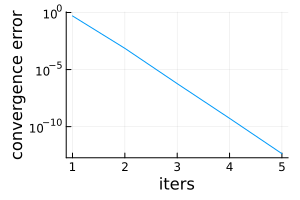

In [102]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200), label="")

In [103]:
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp];

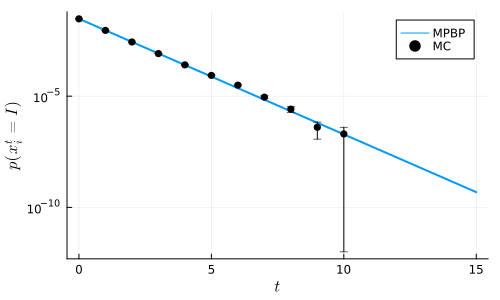

In [104]:
pl = plot(size=(500,300), yaxis=:log10)
p_mc_filtered = replace(mean(p_mc), 0.0=>NaN)
plot!(pl, 0:T, mean(p_bp), lw=2, xlabel=L"t", ylabel=L"p(x_i^t=I)", label="MPBP")
scatter!(pl, 0:T, p_mc_filtered,  c=:black, label="MC")

In [105]:
Tnew = 12

dnew = 8
bpnew = mpbp(SIS(g, λ, ρ, Tnew; γ); d)
cbnew = CB_BP(bpnew)

p_hard = [1.0, 0.0]
for i in 1:N
    bpnew.ϕ[i][end] .= p_hard
end
cbnew = CB_BP(bpnew);

In [106]:
svd_trunc = TruncBondThresh(dnew)
reset!(bpnew)
iters, cbnew = iterate!(bpnew, maxiter=20; svd_trunc, cb=cbnew, tol=1e-10, damp=0.2);

Running MPBP: iter 12 	 Time: 0:01:39
  Δ:                  6.375593420725725e-11
  SVD tolerance, m':  0.0, 8

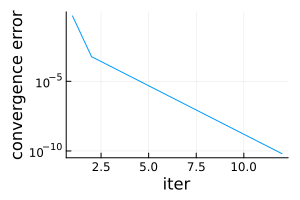

In [107]:
plot(cbnew.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [108]:
# compute marginals
bp_trimmed = bpnew
@show p_dead_epidemic = exp(-bethe_free_energy(bp_trimmed))
b_constrained_ = beliefs(bp_trimmed)
b_constrained = map(1:N) do i
    map(1:T+1) do t
        if t <= Tnew
            b_constrained_[i][t]
        else
            [1.0, 0.0]
        end
    end
end
b_bp_trimmed = b_bp - b_constrained*p_dead_epidemic
p_bp_trimmed = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_bp_trimmed];

p_dead_epidemic = exp(-(bethe_free_energy(bp_trimmed))) = 0.9999991292246905


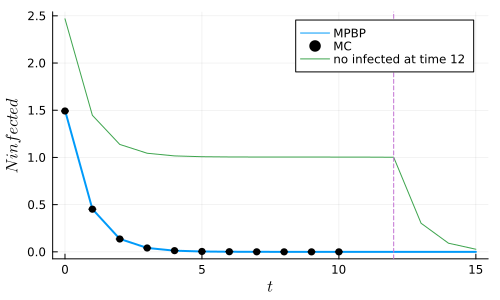

In [114]:
pl2 = plot(size=(500,300), yaxis=:log10)
p_mc_filtered = replace(mean(p_mc), 0.0=>NaN)
plot!(pl2, 0:T, mean(p_bp).*N, lw=2, xlabel=L"t", ylabel=L"N infected", label="MPBP")
scatter!(pl2, 0:T, p_mc_filtered.*N,  c=:black, label="MC")
plot!(pl2, 0:T, mean(p_bp_trimmed).*N, label="no infected at time $Tnew", yaxis=:none)
vline!([Tnew], label="", ls=:dash)

In [70]:
function sis_large_deviations(sis, h_final; 
        showprogress=true, matrix_sizes = [5, 10, 25], tol=1e-3,
        μ = [mpem2(2, 2, T; d=matrix_sizes[1]) for (i,j) in 1:1], info="",
        damp = 0.0)
    normalize!.(μ)
    bp = mpbp(sis)
    for i in 1:N
        bp.ϕ[i][end] .= [1, exp(h_final)]
    end
    cb = CB_BP(bp; showprogress, info)
    bp.μ .= μ
    
    maxiters = fill(100, length(matrix_sizes))
    iters = zeros(Int, length(maxiters))
    for i in eachindex(maxiters)
        iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol, damp)
    end
    
    iters_cum = cumsum(iters)
    inds = 1:iters_cum[1]
    pl_convergence = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
    for i in 2:length(iters)
        inds = iters_cum[i-1]:iters_cum[i]
       plot!(pl_convergence, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
    end
    plot!(pl_convergence, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200))
    
    f(x, i) = x-1
    m = mean(means(f, bp))
    
    pl_convergence, m, bethe_free_energy(bp)/nv(bp.g), bp.μ
end;

In [71]:
hs = [0.0, 3.0, 5.0, 7.0]
fs = zeros(length(hs))
magnetizs = [zeros(T+1) for _ in hs]
ms = zeros(length(hs))
pls = [plot() for _ in hs]
matrix_sizes = [d]

# @telegram "sis large deviations" begin
μ = deepcopy(bp.μ.v); normalize!.(μ)
for i in eachindex(hs)
    h_final = hs[i]
    pls[i], magnetizs[i], fs[i], μnew = sis_large_deviations(sis, h_final; damp=0.0,
        showprogress=true, matrix_sizes, tol=1e-5, μ=μ, info="Round $i of $(length(hs))")
    ms[i] = magnetizs[i][end]
    μ .= μnew
end
# end

Round 1 of 4
Running MPBP: iter 2 	 Time: 0:00:06
  Δ:                6.006306563222097e-16
Round 2 of 4:  6
Running MPBP: iter 2 	 Time: 0:00:05
  Δ:                4.1868551736712333e-10
Round 3 of 4:  6
Running MPBP: iter 2 	 Time: 0:00:05
  Δ:                2.193996632288142e-8
  SVD Matrix size:  6

LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.3017492424047458:
    Exponentiation yielding a complex result requires a complex argument.
    Replace x^y with (x+0im)^y, Complex(x)^y, or similar.
    Stacktrace:
     [1] [0m[1mthrow_exp_domainerror[22m[0m[1m([22m[90mx[39m::[0mFloat64[0m[1m)[22m
    [90m   @ [39m[90mBase.Math[39m [90m./[39m[90m[4mmath.jl:37[24m[39m
     [2] [0m[1m^[22m[0m[1m([22m[90mx[39m::[0mFloat64, [90my[39m::[0mFloat64[0m[1m)[22m
    [90m   @ [39m[90mBase.Math[39m [90m./[39m[90m[4mmath.jl:1003[24m[39m
     [3] [0m[1mnormalize![22m[0m[1m([22m[90mA[39m::[0mMatrixProductBP.MPEMs.MPEM1[90m{Float64}[39m[0m[1m)[22m
    [90m   @ [39m[35mMatrixProductBP.MPEMs[39m [90m~/MatrixProductBP/src/MPEMs/[39m[90m[4mmptrain.jl:182[24m[39m
     [4] [0m[1monebpiter![22m[0m[1m([22m[90mbp[39m::[0mMPBP[90m{IndexedBiDiGraph{Int64}, Float64, Vector{SISFactor{Float64}}}[39m, [90mi[39m::[0mInt64, ::[0mType[90m{SISFactor{Float64}}[39m; [90msvd_trunc[39m::[0mTruncBond, [90mdamp[39m::[0mFloat64[0m[1m)[22m
    [90m   @ [39m[35mMatrixProductBP.Models[39m [90m~/MatrixProductBP/src/Models/[39m[90m[4mrecursive_bp_factor.jl:124[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:179[24m[39m[90m [inlined][39m
     [6] [0m[1m(::MatrixProductBP.var"#582#threadsfor_fun#121"{MatrixProductBP.var"#582#threadsfor_fun#120#122"{TruncBond, Float64, MPBP{IndexedBiDiGraph{Int64}, Float64, Vector{SISFactor{Float64}}}, Vector{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMatrixProductBP[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [7] [0m[1m#582#threadsfor_fun[22m
    [90m   @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [8] [0m[1m(::Base.Threads.var"#1#2"{MatrixProductBP.var"#582#threadsfor_fun#121"{MatrixProductBP.var"#582#threadsfor_fun#120#122"{TruncBond, Float64, MPBP{IndexedBiDiGraph{Int64}, Float64, Vector{SISFactor{Float64}}}, Vector{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

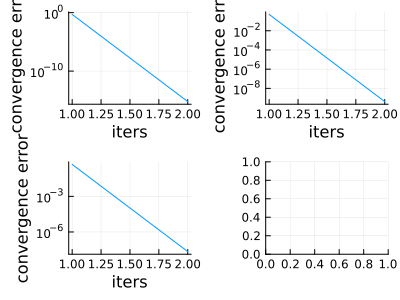

In [72]:
plot(pls..., size=(400,300), legend=false)

In [73]:
cg = RGB.(cgrad(:matter, length(hs)+1, categorical=true))[2:end]
pl = plot(xlabel="t", ylabel="magnetiz", yaxis=:log10)
for i in reverse(eachindex(hs))
    plot!(pl, 0:T, magnetizs[i], c=cg[i], label="h=$(hs[i])")
end
plot!(pl);

In [74]:
pl1 = plot(hs, ms, label="", xlabel="h", ylabel="m", st=:scatter);

In [75]:
pl2 = plot(hs, fs, label="", xlabel="h", ylabel="f", st=:scatter);

In [76]:
gs = hs.*ms .+ fs
pl4 = plot(ms, gs, label="", xlabel="m", ylabel="g", #xlims=(-1,1),
    c=cg, zcolor=hs, colorbar_title=" \nh", st=:scatter);

In [77]:
using LaTeXStrings
st = L"f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=f(h(m))+mh(m)"
display(st)
plot(pl, pl1, pl2, pl4, layout=(2,2), size=(800,500))

L"$f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=f(h(m))+mh(m)$"

┌ Warning: No strict ticks found
└ @ PlotUtils /home/crotti/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/crotti/.julia/packages/PlotUtils/M092a/src/ticks.jl:191


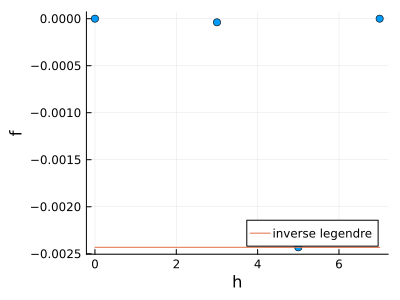

In [78]:
ff = zeros(length(hs))
for i in eachindex(hs)
   ff[i] = minimum(gs[j]-ms[j]*hs[i] for j in eachindex(hs)) 
end
plot!(deepcopy(pl2), hs, ff, label="inverse legendre", size=(400,300), legend=:bottomright)